In [1]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models,datasets
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
dataset_path='/content/drive/MyDrive/garbage-dataset'

In [6]:
image_size = 224
batch_size = 32
dataset_path = '/content/drive/MyDrive/garbage-dataset'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 15627 images belonging to 10 classes.
Found 3902 images belonging to 10 classes.


In [21]:
print(train_generator.class_indices)


{'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [7]:
def build_mobilenetv2_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = False

    inputs = Input(shape=(image_size, image_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

mobilenet_model = build_mobilenetv2_model(num_classes=train_generator.num_classes)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
mobilenet_callbacks = [
    EarlyStopping(
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="/content/drive/MyDrive/mobilenet_best.keras",  # ✅ Save directly to Drive
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]

# 🔹 Train MobileNetV2
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=mobilenet_callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 6787s 14s/step - accuracy: 0.3720 - loss: 1.9060 - val_accuracy: 0.7742 - val_loss: 0.8054
Epoch 2/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 300s 613ms/step - accuracy: 0.7564 - loss: 0.8006 - val_accuracy: 0.8303 - val_loss: 0.5782
Epoch 3/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 298s 610ms/step - accuracy: 0.8095 - loss: 0.6004 - val_accuracy: 0.8483 - val_loss: 0.4829
Epoch 4/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 295s 603ms/step - accuracy: 0.8418 - loss: 0.5043 - val_accuracy: 0.8644 - val_loss: 0.4367
Epoch 5/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 294s 602ms/step - accuracy: 0.8602 - loss: 0.4481 - val_accuracy: 0.8701 - val_loss: 0.4080
Epoch 6/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 297s 607ms/step - accuracy: 0.8665 - loss: 0.4131 - val_accuracy: 0.8783 - val_loss: 0.3863
Epoch 7/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 321s 605ms/step - accuracy: 0.8760 - loss: 0.3906 - val_accuracy: 0.8893 - val_loss: 0.3653
Epoch 8/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 300s 613ms/step - accuracy: 0.8805 - 

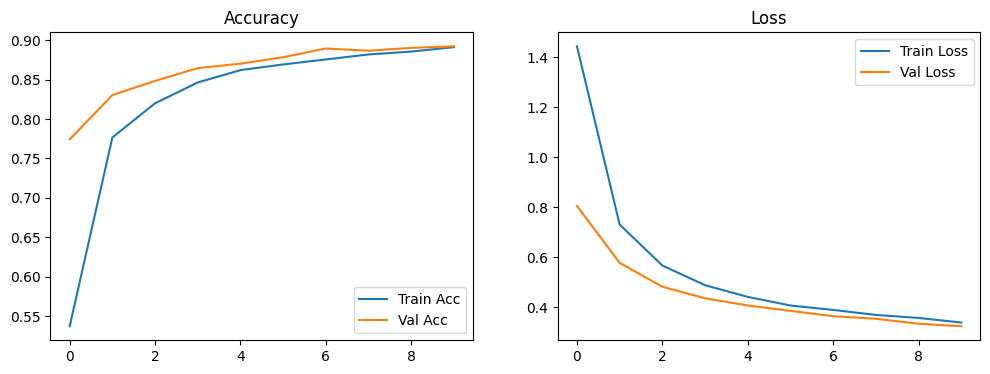

In [9]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(mobilenet_history)

In [ ]:
# ---------------- EfficientNetB0 Training (with Fine-tuning) ---------------- #

# Function to build EfficientNetB0 model and also return base_model
def build_efficientnetb0_model(num_classes, image_size=224):
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(image_size, image_size, 3)
    )
    base_model.trainable = False  # Freeze base model initially

    inputs = Input(shape=(image_size, image_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name="EfficientNetB0_Classifier")
    return model, base_model   # ✅ return both


# Build EfficientNetB0
efficientnetb0_model, base_model = build_efficientnetb0_model(
    num_classes=train_generator.num_classes,
    image_size=image_size
)

# Compile (warm-up stage)
efficientnetb0_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for warm-up
efficientnetb0_callbacks_warmup = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(
        filepath="efficientnetb0_warmup.keras",
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]

# 🔹 Stage 1: Warm-up training (only top layers frozen)
efficientnetb0_history_warmup = efficientnetb0_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=efficientnetb0_callbacks_warmup
)


# 🔹 Stage 2: Fine-tuning
# Unfreeze some EfficientNetB0 layers (e.g. last 100 layers)
for layer in base_model.layers[-100:]:   # ✅ directly use base_model
    layer.trainable = True

# Re-compile with a smaller learning rate
efficientnetb0_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for fine-tuning
efficientnetb0_callbacks_finetune = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(
        filepath="/content/drive/MyDrive/efficientnetb0_finetuned.keras",  # ✅ Save to Drive
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
]

# Fine-tune training
efficientnetb0_history_finetune = efficientnetb0_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=efficientnetb0_callbacks_finetune
)


Epoch 1/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 346s 664ms/step - accuracy: 0.2627 - loss: 2.1586 - val_accuracy: 0.2745 - val_loss: 2.1219
Epoch 2/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 307s 628ms/step - accuracy: 0.2714 - loss: 2.1368 - val_accuracy: 0.2745 - val_loss: 2.1234
Epoch 3/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 305s 624ms/step - accuracy: 0.2679 - loss: 2.1425 - val_accuracy: 0.2745 - val_loss: 2.1218
Epoch 4/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 305s 623ms/step - accuracy: 0.2693 - loss: 2.1458 - val_accuracy: 0.2745 - val_loss: 2.1224
Epoch 5/5
489/489 ━━━━━━━━━━━━━━━━━━━━ 305s 625ms/step - accuracy: 0.2672 - loss: 2.1466 - val_accuracy: 0.2745 - val_loss: 2.1225
Epoch 1/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 384s 701ms/step - accuracy: 0.1639 - loss: 2.3140 - val_accuracy: 0.1753 - val_loss: 2.2058
Epoch 2/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 309s 632ms/step - accuracy: 0.3029 - loss: 2.0433 - val_accuracy: 0.1907 - val_loss: 2.2405
Epoch 3/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 331s 677ms/step - accuracy: 0.3239 - loss

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# ---------------- MobileNetV2 Evaluation ---------------- #
y_true = val_generator.classes
y_pred_mn_probs = mobilenet_model.predict(val_generator)
y_pred_mn = np.argmax(y_pred_mn_probs, axis=1)

acc_mn = accuracy_score(y_true, y_pred_mn)
prec_mn = precision_score(y_true, y_pred_mn, average='weighted')
rec_mn = recall_score(y_true, y_pred_mn, average='weighted')
f1_mn = f1_score(y_true, y_pred_mn, average='weighted')

print("\n📌 MobileNetV2 Performance")
print(f"Accuracy: {acc_mn:.4f}")
print(f"Precision: {prec_mn:.4f}")
print(f"Recall: {rec_mn:.4f}")
print(f"F1-Score: {f1_mn:.4f}")
print("\nClassification Report (MobileNetV2):")
print(classification_report(y_true, y_pred_mn))


# ---------------- EfficientNetB0 Evaluation ---------------- #
y_pred_en_probs = efficientnetb0_model.predict(val_generator)
y_pred_en = np.argmax(y_pred_en_probs, axis=1)

acc_en = accuracy_score(y_true, y_pred_en)
prec_en = precision_score(y_true, y_pred_en, average='weighted')
rec_en = recall_score(y_true, y_pred_en, average='weighted')
f1_en = f1_score(y_true, y_pred_en, average='weighted')

print("\n📌 EfficientNetB0 Performance")
print(f"Accuracy: {acc_en:.4f}")
print(f"Precision: {prec_en:.4f}")
print(f"Recall: {rec_en:.4f}")
print(f"F1-Score: {f1_en:.4f}")
print("\nClassification Report (EfficientNetB0):")
print(classification_report(y_true, y_pred_en))


122/122 ━━━━━━━━━━━━━━━━━━━━ 69s 527ms/step

📌 MobileNetV2 Performance
Accuracy: 0.1453
Precision: 0.1438
Recall: 0.1453
F1-Score: 0.1445

Classification Report (MobileNetV2):
              precision    recall  f1-score   support

           0       0.03      0.04      0.04       188
           1       0.04      0.03      0.04       201
           2       0.09      0.09      0.09       302
           3       0.28      0.28      0.28      1071
           4       0.16      0.17      0.16       614
           5       0.04      0.03      0.03       204
           6       0.11      0.11      0.11       338
           7       0.10      0.09      0.09       396
           8       0.09      0.09      0.09       397
           9       0.03      0.03      0.03       191

    accuracy                           0.15      3902
   macro avg       0.10      0.10      0.10      3902
weighted avg       0.14      0.15      0.14      3902

122/122 ━━━━━━━━━━━━━━━━━━━━ 74s 546ms/step

📌 EfficientNetB0 Per

In [35]:
%%writefile garbageimage.py
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

from PIL import Image

# ✅ Page config
st.set_page_config(page_title="Garbage Image Classification using Computer Vision", layout="wide")

# Sidebar navigation
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to", ["Introduction", "Data Overview", "Model Insights", "Classification"])

# Introduction page
if page == "Introduction":
    st.title("Garbage Image Classification using Computer Vision")
    st.write("""
    Welcome to the **Garbage Image Classification App**! 🌍♻️

    Waste management is a global challenge, and separating garbage into the correct categories is
    essential for recycling and sustainable living.

    This project leverages **deep learning** and **computer vision** to classify garbage images into
    multiple categories such as paper, plastic, glass, metal, and more.

    Using a trained **MobileNetV2 model**, this app can predict the type of waste from an uploaded image.
    """)

elif page == "Data Overview":
    st.title("Data Overview")
    st.write("""
    The dataset used in this project consists of **10 categories of garbage images**:

    - Battery
    - Biological
    - Cardboard
    - Clothes
    - Glass
    - Metal
    - Paper
    - Plastic
    - Shoes
    - Trash

    Each class contains hundreds of images, allowing the model to learn unique features of
    different waste types.

    The dataset is divided into:
    - **Training set (80%)** for model learning
    - **Validation set (20%)** for evaluating performance during training
    """)


elif page == "Model Insights":
    st.title("Model Insights & Working")

    st.write("""
    This page explains **how the Garbage Image Classification model works** and provides some
    insights into its performance.

    **1. Model Architecture:**
    - We use a **MobileNetV2** model pre-trained on ImageNet as the backbone.
    - The top layers are replaced with:
        - Global Average Pooling
        - Dense layer with ReLU activation
        - Dropout layer for regularization
        - Final Dense layer with Softmax activation for 10 garbage classes

    **2️. Training Strategy:**
    - Data Augmentation: rotation, horizontal flips, zoom, and rescaling.
    - Training/Validation split: 80%/20%.
    - Optimizer: Adam with a learning rate scheduler (optional for better convergence).
    - EarlyStopping and ModelCheckpoint to prevent overfitting and save the best model.

    **3. Model Performance:**
    - Accuracy, Precision, Recall, and F1-Score are evaluated on the validation set.
    - Confusion matrix can help visualize which classes the model confuses the most.

    **4. Future Improvements:**
    - Use **EfficientNetB3 or B4** for higher accuracy.
    - Increase input image size (260-300px).
    - Fine-tune more layers of the pre-trained backbone.
    - Apply advanced augmentations like cutout, mixup, or random brightness/contrast.

    **5. Social Impact:**
    - Automated garbage classification can help improve recycling efficiency, reduce landfill waste,
      and promote sustainable waste management. 🌱
    """)

    st.subheader("Confusion Matrix Example")
    st.write("""
    You can generate a **confusion matrix** to see which garbage classes are being misclassified
    most often. This is a key tool in understanding model behavior.
    """)


elif page == "Classification":
    st.title("Garbage Image Classification")

    st.write("""
    Upload an image of garbage, and the trained model will predict its class.

    Steps:
    1. Upload an image in JPG or PNG format.
    2. The image is preprocessed (resized to 224x224, normalized).
    3. The MobileNetV2 model predicts the **most likely garbage category**.

    ✅ This tool can assist in **automatic waste sorting**, promoting recycling and sustainability.
    """)

    # Load trained model
    try:
        model = load_model("/content/drive/MyDrive/mobilenet_best.keras")
    except Exception as e:
        st.error(f"❌ Could not load model: {e}")
        st.stop()

    class_names = [
    "battery", "biological", "cardboard", "clothes", "glass",
    "metal", "paper", "plastic", "shoes", "trash"]


    # Upload image for classification
    uploaded_file = st.file_uploader("Choose an image", type=["jpg", "jpeg", "png"])
    if uploaded_file is not None:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Uploaded Image", use_column_width=True)

        # Preprocessing
        image_size = 224
        img = image.resize((image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prediction
        prediction = model.predict(img_array)
        predicted_class_idx = np.argmax(prediction, axis=1)[0]
        predicted_class_name = class_names[predicted_class_idx]

        st.success(f"✅ Predicted Class: {predicted_class_name}")




Overwriting garbageimage.py


In [36]:
!streamlit run garbageimage.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8505
  Network URL: http://172.28.0.12:8505
  External URL: http://34.16.183.72:8505

  Stopping...


In [37]:
!streamlit run garbageimage.py &>/dev/null&

In [14]:
!pip install streamlit pyngrok -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.9 MB/s eta 0:00:00


In [18]:
!which streamlit


/usr/local/bin/streamlit


In [38]:
!streamlit run garbageimage.py --server.port 8501




2025-09-21 15:18:50.122 Port 8501 is already in use


In [39]:
!pip install pyngrok -q
from pyngrok import ngrok
from google.colab import userdata

# Terminate open tunnels if any
ngrok.kill()

# Get a ngrok authtoken from https://dashboard.ngrok.com/auth
# and paste it in the secrets tab on the left sidebar.
# Then uncomment the following line:
NGrok_Auth = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(NGrok_Auth)

# Open a tunnel to the port where Streamlit is running
public_url = ngrok.connect(8501)
print(f"Streamlit App URL: {public_url}")

Streamlit App URL: NgrokTunnel: "https://30c8e3d2e1cd.ngrok-free.app" -> "http://localhost:8501"
